In [1]:
import gym
import matplotlib.pyplot as plt
import IPython.display as display
import time
from pyswip import Prolog
from minihack import LevelGenerator
from minihack import RewardManager

In [16]:
def create_level(width: int, height: int, weapon: str):
    lvl = LevelGenerator(w=width, h=height)
    # lvl.add_monster(name=monster)
    # lvl.add_trap(name=trap)
    # lvl.add_object(name='apple', symbol='%')
    # lvl.set_start_pos((2, 3))
    # lvl.add_goal_pos()
    # lvl.add_stair_down == lvl.add_goal_pos()
    lvl.add_object(name=weapon, symbol=')')
    # lvl.add_object(name=armor, symbol='[')

    return lvl.get_des()

def define_reward(weapon: str):
    reward_manager = RewardManager()

    # reward_manager.add_eat_event(name='apple', reward=2, terminal_sufficient=True, terminal_required=True)
    # reward_manager.add_kill_event(name=monster, reward=1, terminal_required=False)
    
    # reward_manager.add_location_event(location='stairs',reward=2,terminal_sufficient=True, terminal_required=True)
    reward_manager.add_wield_event(name=weapon, reward=1,terminal_sufficient=True, terminal_required=True)
    # reward_manager.add_wear_event(name=armor, reward=1,terminal_required=False)

    return reward_manager

In [17]:
MAX_STEPS = 30
heigth = 12
width = 12
# attempts = 5
# max_steps = 30
# monster = 'kobold'
weapon = 'dagger'
# armor = 'chain mail'
file = 'simple_kb.pl'

In [19]:
des_file = create_level(width=width, height=heigth, weapon=weapon)
reward_manager = define_reward(weapon=weapon)

In [63]:
env = gym.make('MiniHack-Skill-Custom-v0',
               character="wiz-elf-neu-mal",
               observation_keys=('screen_descriptions','inv_strs','blstats','message','pixel','chars'),
               des_file=des_file,
               reward_manager=reward_manager)

In [64]:
state = env.reset()
env.render()


Hello Agent, welcome to NetHack!  You are a chaotic male elven Wizard.          
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                  ...........@                                  
                                  ............                                  
                                  ............                                  
                                  ............                                  
                                  ............                                  
                                  ............                                  
                           

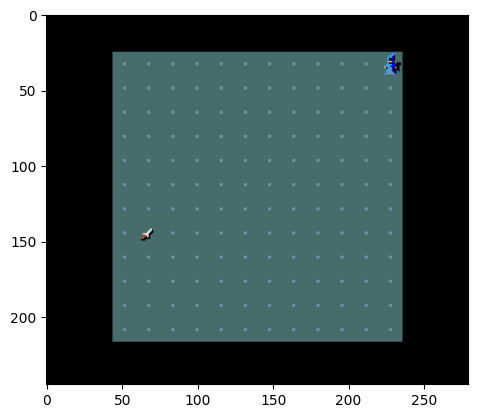

In [65]:
plt.imshow(state['pixel'][55:300, 500:780])

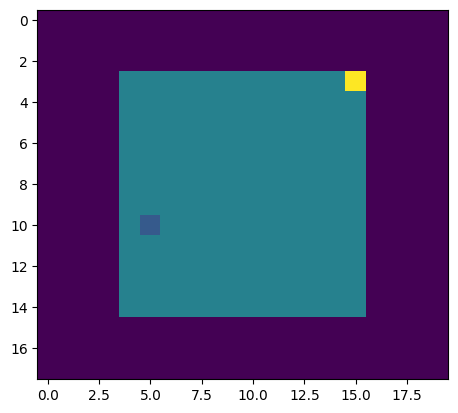

In [66]:
plt.imshow(state['chars'][2:20, 30:50])

In [67]:
KB = Prolog()
KB.consult(file)

In [68]:
def process_state(state: dict, kb: Prolog, weapon: str):
    # print('qui')
    kb.retractall("position(_,_,_,_)")

    # viene analizzata cella per cella (i,j) tutta la mappa
    for i in range(21):
        for j in range(79):
            # si controlla se nella cella (i,j) è presente qualcosa 
            if not (state['screen_descriptions'][i][j] == 0).all():
                # se è presente qualcosa se ne estrapola il contenuto
                obj = bytes(state['screen_descriptions'][i][j]).decode('utf-8').rstrip('\x00')
                if 'dagger' in obj:
                    kb.asserta(f'position(weapon, {weapon}, {i}, {j})')
                    print(f'riconosciuta {weapon} in {i},{j}')
                # if 'stairs' in obj:
                #     kb.asserta(f'position(stairs, {weapon}, {i}, {j})')
                #     print(f'riconosciuta {weapon} in {i},{j}')
                               
    kb.retractall("wields_weapon(_,_)")
    kb.retractall("own(agent,_,_)")  
    # si itera attraverso gli oggetti nell'inventario dell'agente  
    for obj in state['inv_strs']:
        # si decodifica l'oggetto dall'inventario
        obj = bytes(obj).decode('utf-8').rstrip('\x00')
        if 'weapon in hand' in obj:
            # the actual name of the weapon is in position 2
            wp = obj.split()[2]
            kb.asserta(f'wields_weapon(agent, {wp})')
            # kb.asserta('own(agent, weapon, dagger)')
            print('in da inventory 1')
        if 'dagger' in obj:
            kb.asserta('own(agent, weapon, dagger)')
            print('in da inventory 2')


    kb.retractall("position(agent,_,_,_)")
    # Asserisce la nuova posizione dell'agente nella knowledge base
    kb.asserta(f"position(agent, _, {state['blstats'][1]}, {state['blstats'][0]})")

    message = bytes(state['message']).decode('utf-8').rstrip('\x00')
    if 'You see here' in message:
        if 'dagger' in message:
            kb.asserta(f'stepping_on(agent, weapon, {weapon})')
    # print('qua')

In [69]:
def perform_action(action, env):

    print('Performing an action')
    if action == 'pick_up': action_id = 49
    elif action == 'wield': action_id = 78

    # go_to_weapon(Direction)/go_to_stairs(Direction) actions all are movement in a direction
    elif 'north'        in action: action_id = 0
    elif 'east'         in action: action_id = 1
    elif 'south'        in action: action_id = 2
    elif 'west'         in action: action_id = 3
    elif 'northeast'    in action: action_id = 4
    elif 'southeast'    in action: action_id = 5
    elif 'southwest'    in action: action_id = 6
    elif 'northwest'    in action: action_id = 7

    print(f'Action performed: {repr(env.actions[action_id])}')
    state, reward, done, info = env.step(action_id)
    return state, reward, done, info

In [70]:
# indexes for showing the image are hard-coded
def show_match(states: list):
    image = plt.imshow(states[0][55:300, 500:780])
    for state in states[1:]:
        time.sleep(0.25)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        image.set_data(state[55:300, 500:780])
    time.sleep(0.25)
    display.display(plt.gcf())
    display.clear_output(wait=True)

Risolto in 0 steps


NameError: name 'info' is not defined

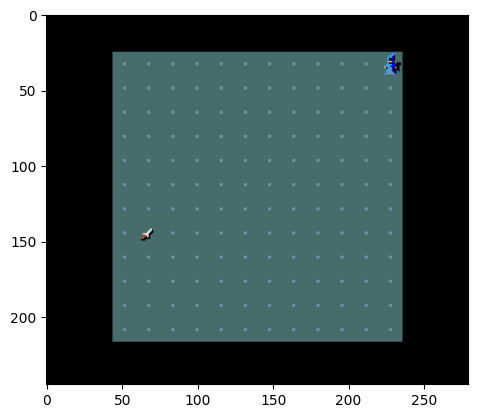

In [73]:
done = False
steps = 0
reward = 0.0
map_states = []
# state = env.reset()
map_states.append(state['pixel'])

while not done and steps < MAX_STEPS:
    # Get the observation from the env and assert the facts in the kb 
    process_state(state, KB, weapon)
    
    try:
        action = list(KB.query('action(X)'))[0]
        action = action['X']
        print(f'>> Current action from Prolog: {action}')
    except Exception as e:
        action = None

    # Perform the action in the environment
    if action:
        print(f'done is {done}')
        state, reward, done, info = perform_action(action, env)
        print(f'done is {done}')
        # memorizzo lambiente 'pixel' frame by grame (o meglio dire azione per azione)
        map_states.append(state['pixel'])
        # env.render()
    else:
        print("ERROR: impossible to perform any action. Please check assertions and definitions in KB.")
        break
        
    steps += 1


# Display game with interface
show_match(map_states)
# Print information about the ended episode
print(f'Risolto in {steps} steps')
print(f'End status: {info["end_status"].name}')
print(f'Final reward: {reward}')
time.sleep(0.75)

# reset the environment and retract axioms that may cause errors
state = env.reset()
KB.retractall('stepping_on(agent,_,_)')

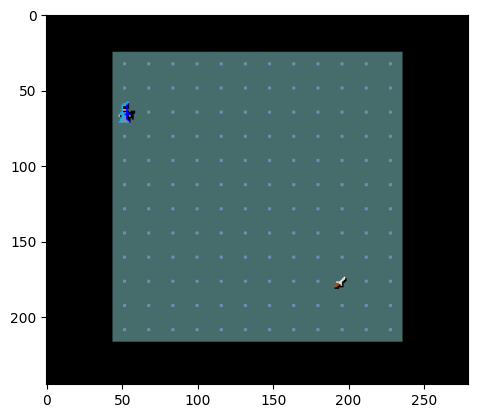

In [30]:
plt.imshow(state['pixel'][55:300, 500:780])